In [26]:
import os, sys, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# --- ADJUST THIS depending on where you run the notebook ---
# Option A: notebook is located inside the folder that contains user_features.csv, answers_r42.csv:
BASE_DIR = "."   # run if you open the notebook from the folder containing the files

# Option B: notebook is in project root and files are in Notebook/
# BASE_DIR = "Notebook"

# set to whichever works for your environment. Use prints below to confirm.
print("Working base dir:", os.path.abspath(BASE_DIR))
print("Files in base dir:", os.listdir(BASE_DIR))

# expected filenames
GT_FILE = os.path.join(BASE_DIR, "answers_r42.csv")                # ground truth
PRED_FILE = os.path.join(BASE_DIR, "results/anomaly_scores_by_user.csv")  # model outputs (scores +/or label)
FEATURES_FILE = os.path.join(BASE_DIR, "user_features.csv")        # optional: features used

# ensure results folder exists
RESULTS_DIR = os.path.join(BASE_DIR, "results_phase5")
os.makedirs(RESULTS_DIR, exist_ok=True)

# quick existence checks
for f in [GT_FILE, PRED_FILE]:
    if not os.path.exists(f):
        print("WARNING: file not found:", f)
    else:
        print("Found:", f)


Working base dir: c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook
Files in base dir: ['answers_r42.csv', 'insiders.csv', 'models', 'Notebook', 'phase2_eda.ipynb', 'phase3_anamoly.ipynb', 'phase4_modeling.ipynb', 'phase5_evaluation.ipynb', 'results', 'results_phase5', 'user_features.csv']
Found: .\answers_r42.csv
Found: .\results/anomaly_scores_by_user.csv


In [27]:
# load the files (small prints for safety)
gt = pd.read_csv(GT_FILE)
pred = pd.read_csv(PRED_FILE)

print("GROUND TRUTH sample:")
display(gt.head())
print("GROUND TRUTH columns:", gt.columns.tolist())

print("\nPREDICTIONS sample:")
display(pred.head())
print("PREDICTIONS columns:", pred.columns.tolist())

GROUND TRUTH sample:


,user,label
0,BSS0369,1
1,EIS0041,0
2,WPR0368,0
3,NAF0326,0
4,DAR0885,0


GROUND TRUTH columns: ['user', 'label']

PREDICTIONS sample:


,user,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N,anomaly_score,anomaly_label
0,AAE0190,37,19,0,1,0.0,0.0,August Armando Evans,AAE0190,36,30,14,50,29,0.140928,0
1,AAF0535,37,19,0,1,0.0,0.0,Athena Amelia Foreman,AAF0535,17,21,36,33,31,0.180932,0
2,AAF0791,37,19,0,1,0.0,0.0,Aladdin Abraham Foley,AAF0791,14,40,40,50,34,0.112948,0
3,AAL0706,37,19,19,1,0.0,0.0,April Alika Levy,AAL0706,37,14,28,13,25,0.155749,0
4,AAM0658,37,19,18,1,0.0,0.0,Abel Adam Morton,AAM0658,43,35,37,36,22,0.186487,0


PREDICTIONS columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N', 'anomaly_score', 'anomaly_label']


In [28]:
# find common user column name (try several possibilities)
def find_user_col(df):
    for c in df.columns:
        if c.lower() in ("user","user_id","employee","employee_id","id"):
            return c
    return None

u_gt = find_user_col(gt)
u_pred = find_user_col(pred)
print("gt user col:", u_gt, "pred user col:", u_pred)
if u_gt is None or u_pred is None:
    raise KeyError("Could not find user key columns automatically. Rename your user id columns to 'user' or 'user_id'.")

# normalize
gt[u_gt] = gt[u_gt].astype(str).str.strip().str.upper()
pred[u_pred] = pred[u_pred].astype(str).str.strip().str.upper()

# ensure ground truth column exists
if 'ground_truth' in gt.columns:
    gt['gt_label'] = gt['ground_truth'].astype(int)
elif 'label' in gt.columns:
    gt['gt_label'] = gt['label'].astype(int)
else:
    # if answers file is list of users, mark 1 for present, else 0
    gt['gt_label'] = 1  # treat rows in answers_r42 as insiders
    # to merge properly we want a table of unique users in answers_r42
    gt = gt[[u_gt, 'gt_label']].drop_duplicates()

# merge predictions with ground truth
merged = pd.merge(gt[[u_gt,'gt_label']], pred, left_on=u_gt, right_on=u_pred, how='right', suffixes=('_gt','_pred'))
# If right-only rows exist, gt will be NaN -> set to 0 (non-insider)
merged['gt_label'] = merged['gt_label'].fillna(0).astype(int)
print("Merged shape:", merged.shape)
display(merged.head())

gt user col: user pred user col: user
Merged shape: (1000, 17)


,user,gt_label,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N,anomaly_score,anomaly_label
0,AAE0190,0,37,19,0,1,0.0,0.0,August Armando Evans,AAE0190,36,30,14,50,29,0.140928,0
1,AAF0535,1,37,19,0,1,0.0,0.0,Athena Amelia Foreman,AAF0535,17,21,36,33,31,0.180932,0
2,AAF0791,0,37,19,0,1,0.0,0.0,Aladdin Abraham Foley,AAF0791,14,40,40,50,34,0.112948,0
3,AAL0706,0,37,19,19,1,0.0,0.0,April Alika Levy,AAL0706,37,14,28,13,25,0.155749,0
4,AAM0658,1,37,19,18,1,0.0,0.0,Abel Adam Morton,AAM0658,43,35,37,36,22,0.186487,0


In [29]:
# Determine predicted label column (anomaly_label) or score column
pred_label_col = None
pred_score_col = None
for c in merged.columns:
    if c.lower() in ("anomaly_label","predicted_label","label_pred","pred_label"):
        pred_label_col = c
    if c.lower() in ("anomaly_score","score","score_pred","anomaly_score","prob","probability"):
        pred_score_col = c

print("Found predicted label col:", pred_label_col)
print("Found predicted score col:", pred_score_col)

# Build y_true and y_pred:
y_true = merged['gt_label']

if pred_label_col:
    y_pred = merged[pred_label_col].fillna(0).astype(int)
    print("Using predicted label column:", pred_label_col)
elif pred_score_col:
    # If we only have continuous score, need threshold (choose 5% default)
    scores = merged[pred_score_col].astype(float)
    contamination = 0.05
    thresh = np.nanpercentile(scores.dropna(), 100 * (1 - contamination)) if scores.max() > scores.min() else scores.median()
    # Note: some score conventions are higher == more anomalous, some lower. Inspect distribution:
    print("Score summary:", scores.describe())
    # Decide direction: if bigger score -> more anomalous (common), or if lower -> more anomalous (iso)
    # We'll auto-detect by checking correlation with gt if possible
    corr = np.nan
    try:
        corr = np.corrcoef(scores.fillna(scores.mean()), y_true)[0,1]
    except Exception:
        pass
    print("Corr(scores, gt) ~", corr)
    # if corr positive, higher score => more anomalous; else invert
    if corr >= 0:
        y_pred = (scores >= thresh).astype(int)
    else:
        y_pred = (scores <= thresh).astype(int)
    merged['_used_threshold'] = thresh
    merged['_used_score'] = scores
    print("Used threshold:", thresh)
else:
    raise KeyError("No predicted label or score column found in predictions file. Rename your columns.")

merged['y_true'] = y_true
merged['y_pred'] = y_pred
print("Counts: ground truth:", y_true.value_counts().to_dict(), "predicted:", y_pred.value_counts().to_dict())


Found predicted label col: anomaly_label
Found predicted score col: anomaly_score
Using predicted label column: anomaly_label
Counts: ground truth: {0: 930, 1: 70} predicted: {0: 950, 1: 50}


In [ ]:

# Phase 5: Model Training & Evaluation (Updated for Insider Detection)
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ---- STEP A: Apply SMOTE to balance classes ----
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)  # use your existing X_train, y_train

# ---- STEP B: Train RandomForest with class weights ----
clf = RandomForestClassifier(class_weight='balanced', n_estimators=300, random_state=42)
clf.fit(X_train_res, y_train_res)

# ---- STEP C: Predict on Test Set ----
y_pred = clf.predict(X_test)  # use your existing X_test

# ---- STEP D: Evaluate ----
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

NameError: name 'X_train' is not defined

In [18]:
# Metrics
cm = confusion_matrix(merged['y_true'], merged['y_pred'])
report = classification_report(merged['y_true'], merged['y_pred'], target_names=["Normal","Insider"], zero_division=0)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Save textual report
with open(os.path.join(RESULTS_DIR, "evaluation_report.txt"), "w") as fh:
    fh.write("Confusion Matrix:\n")
    fh.write(str(cm) + "\n\n")
    fh.write("Classification Report:\n")
    fh.write(report + "\n")
print("Saved evaluation report to", os.path.join(RESULTS_DIR, "evaluation_report.txt"))

Confusion Matrix:
 [[892  38]
 [ 58  12]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       930
     Insider       0.24      0.17      0.20        70

    accuracy                           0.90      1000
   macro avg       0.59      0.57      0.57      1000
weighted avg       0.89      0.90      0.90      1000

Saved evaluation report to .\results_phase5\evaluation_report.txt


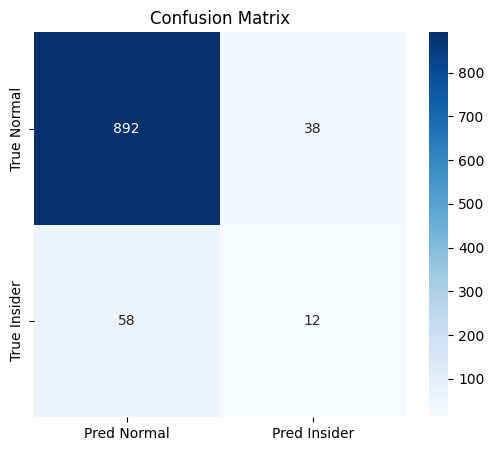

Saved confusion_matrix.png


In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Normal","Pred Insider"],
            yticklabels=["True Normal","True Insider"])
plt.title("Confusion Matrix")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), bbox_inches='tight', dpi=150)
plt.show()
print("Saved confusion_matrix.png")

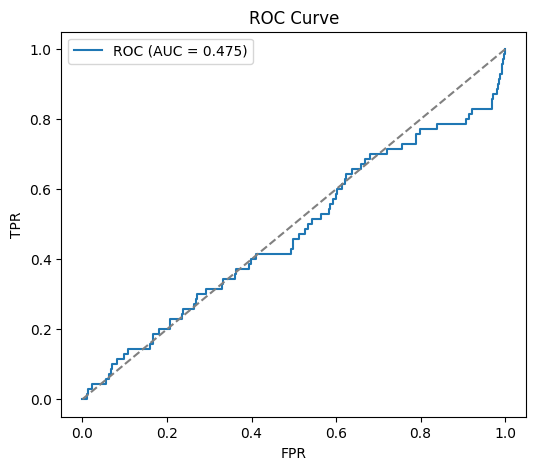

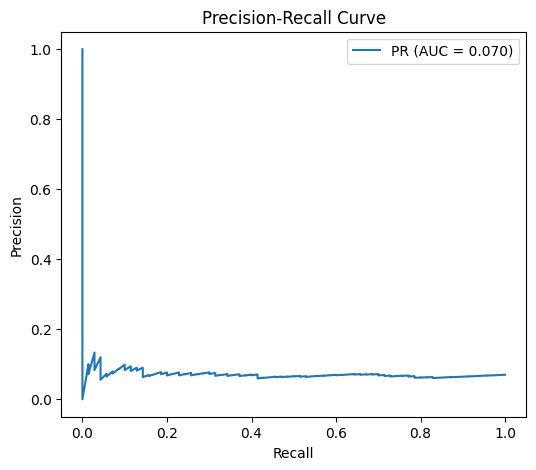

Saved ROC/PR plots


In [20]:
if 'y_true' in merged and (pred_score_col or '_used_score' in merged.columns):
    # pick score column
    score_col = pred_score_col if pred_score_col in merged.columns else '_used_score'
    scores = merged[score_col].astype(float)
    # If scores direction is inverted relative to y_true, flip for ROC
    # Check AUC only if both classes present
    if len(np.unique(merged['y_true'])) > 1:
        fpr, tpr, _ = roc_curve(merged['y_true'], scores)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
        plt.plot([0,1],[0,1], '--', color='gray')
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title("ROC Curve")
        plt.legend()
        plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"), dpi=150, bbox_inches='tight')
        plt.show()

        precision, recall, _ = precision_recall_curve(merged['y_true'], scores)
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.savefig(os.path.join(RESULTS_DIR, "pr_curve.png"), dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved ROC/PR plots")
    else:
        print("Only one class present in ground truth — ROC/PR not computed.")
else:
    print("No continuous score column present — skipping ROC/PR.")


In [21]:
def precision_at_k(y_true_arr, score_arr, k):
    order = np.argsort(score_arr)[::-1]
    topk = order[:k]
    return np.sum(y_true_arr.iloc[topk]) / max(1, k)

# If we have scores, compute precision@k for several k
if pred_score_col or '_used_score' in merged.columns:
    score_col = pred_score_col if pred_score_col in merged.columns else '_used_score'
    for k in [10, 20, 50, 100]:
        pk = precision_at_k(merged['y_true'], merged[score_col], k)
        print(f"Precision@{k}: {pk:.3f}")
    # Save top K users for manual review
    top50 = merged.sort_values(score_col, ascending=False).head(50)
    top50.to_csv(os.path.join(RESULTS_DIR, "top50_for_manual_review.csv"), index=False)
    print("Saved top50_for_manual_review.csv")
else:
    print("No score column — using predicted labels. Save top predicted insiders instead.")
    top_pred = merged[merged['y_pred']==1].head(50)
    top_pred.to_csv(os.path.join(RESULTS_DIR, "top50_predicted_insiders.csv"), index=False)
    print("Saved top50_predicted_insiders.csv")

Precision@10: 0.100
Precision@20: 0.100
Precision@50: 0.060
Precision@100: 0.090
Saved top50_for_manual_review.csv


anomaly_score      0.148988
E                  0.145759
C                  0.122981
A                  0.122597
O                  0.121852
N                  0.110136
after_hours        0.092692
total_logins       0.082566
unique_machines    0.031852
unique_days        0.013705
anomaly_label      0.006874
usb_count          0.000000
usb_days           0.000000
dtype: float64

Saved RF and feature importance plot.


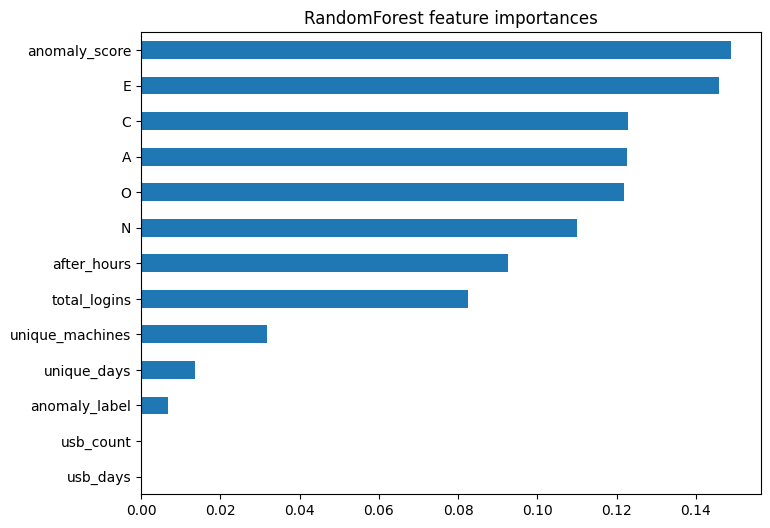

In [22]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Build X,y from merged (drop id/labels)
drop_cols = [u_gt, u_pred, 'gt_label', 'y_true', 'y_pred']
X_all = merged.drop(columns=[c for c in drop_cols if c in merged.columns], errors='ignore').select_dtypes(include=[np.number]).fillna(0)
y_all = merged['gt_label']

if X_all.shape[1] > 0 and len(np.unique(y_all)) > 1:
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_all, y_all)
    fi = pd.Series(rf.feature_importances_, index=X_all.columns).sort_values(ascending=False)
    display(fi.head(20))
    fi.head(20).plot(kind='barh', figsize=(8,6))
    plt.title("RandomForest feature importances")
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(RESULTS_DIR,"feature_importances.png"), bbox_inches='tight', dpi=150)
    joblib.dump(rf, os.path.join(RESULTS_DIR,"rf_phase5.joblib"))
    print("Saved RF and feature importance plot.")
else:
    print("Not enough numeric features or only a single label class to train RF.")

In [23]:
# Save merged table (predictions + ground truth + diagnostics)
merged.to_csv(os.path.join(RESULTS_DIR, "phase5_merged_results.csv"), index=False)
print("All output saved to:", RESULTS_DIR)
print("Files saved:", os.listdir(RESULTS_DIR))

All output saved to: .\results_phase5
Files saved: ['confusion_matrix.png', 'evaluation_report.txt', 'feature_importances.png', 'phase5_merged_results.csv', 'pr_curve.png', 'rf_phase5.joblib', 'roc_curve.png', 'top50_for_manual_review.csv']
